In [15]:
# ============================================================
# 1. Imports y configuración
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)


In [16]:
# ============================================================
# 2. Carga de datos: adult.data y adult.test
# ============================================================

columns = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week", "native-country",
    "income"
]

# Cargar train
df_train = pd.read_csv(
    "adult.data",
    header=None,
    names=columns,
    na_values=" ?",
    skipinitialspace=True
)

# Cargar test (primera fila es cabecera basura)
df_test = pd.read_csv(
    "adult.test",
    header=None,
    names=columns,
    na_values=" ?",
    skipinitialspace=True,
    skiprows=1
)

print("Tamaño train:", df_train.shape)
print("Tamaño test :", df_test.shape)

# Unir ambos
df = pd.concat([df_train, df_test], axis=0, ignore_index=True)
print("Tamaño combinado:", df.shape)


Tamaño train: (32561, 15)
Tamaño test : (16281, 15)
Tamaño combinado: (48842, 15)


In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# ============================================================
# 3. Limpieza de income y nulos
# ============================================================

# Normalizar income: quitar puntos finales y espacios
df["income"] = (
    df["income"]
    .astype(str)
    .str.strip()
    .str.replace(".", "", regex=False)
)

print("Valores únicos income antes de filtrar:", df["income"].unique())

# Eliminar filas que no tengan income válido
df = df[df["income"].isin(["<=50K", ">50K"])].copy()
print("Tamaño después de filtrar income inválido:", df.shape)

# Revisar nulos
print("\nConteo de nulos por columna:")
print(df.isna().sum())


Valores únicos income antes de filtrar: ['<=50K' '>50K']
Tamaño después de filtrar income inválido: (48842, 15)

Conteo de nulos por columna:
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64


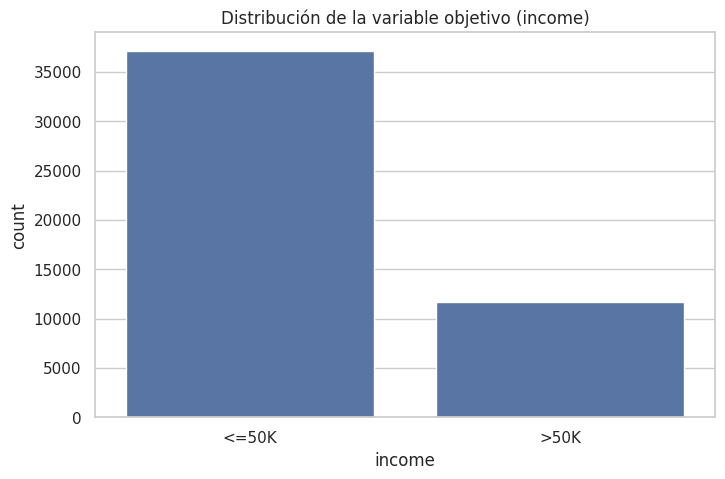


Distribución relativa de income:
income
<=50K    0.760718
>50K     0.239282
Name: proportion, dtype: float64


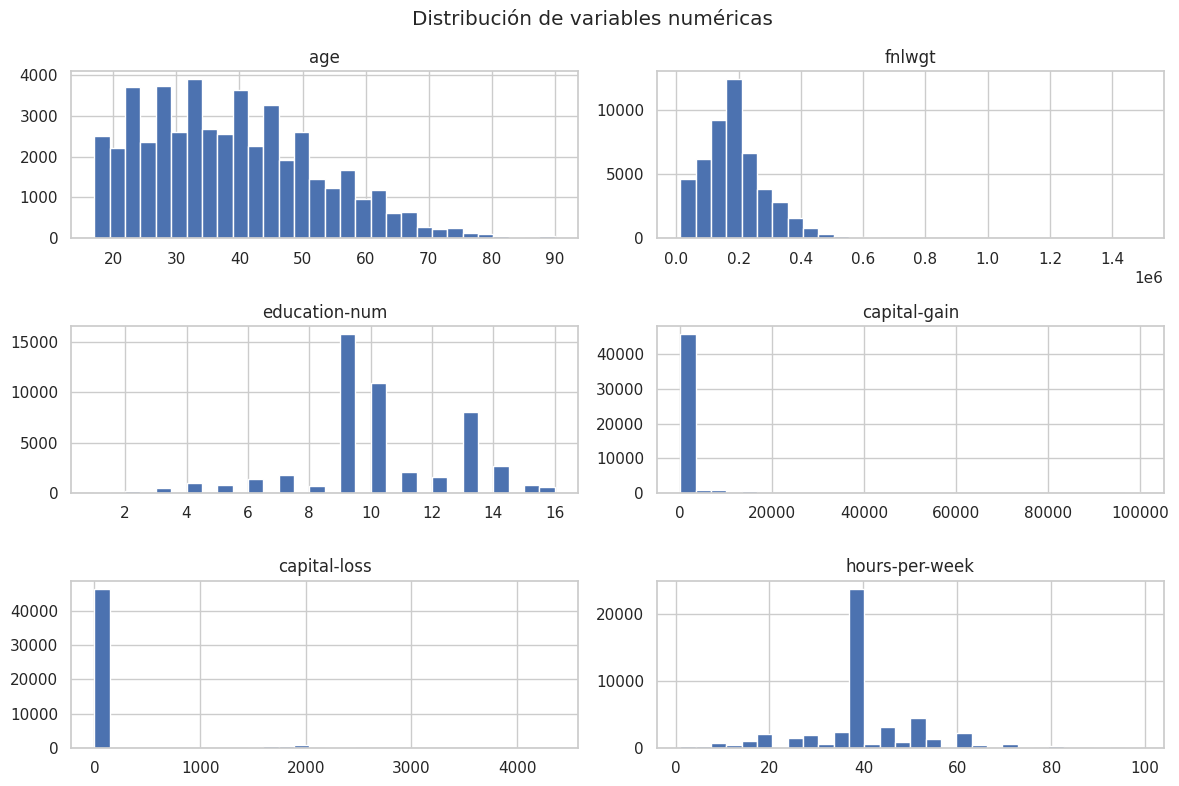

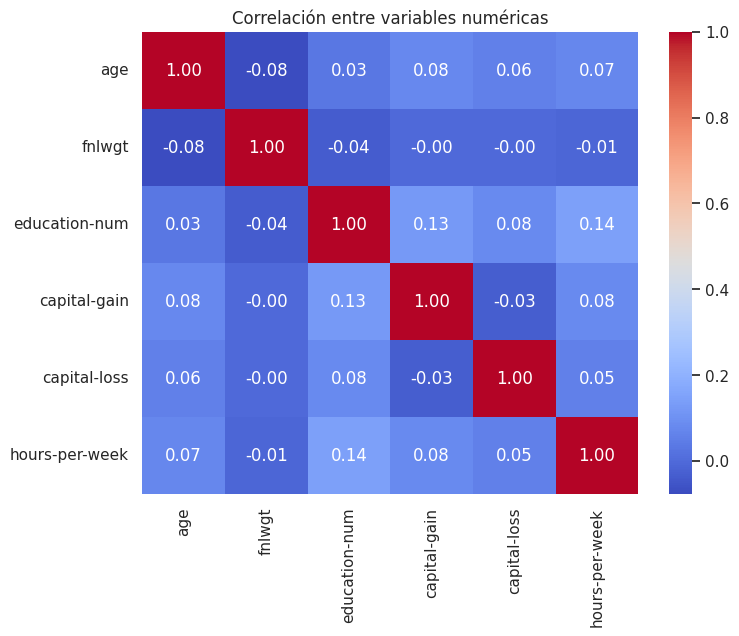

In [19]:
# ============================================================
# 4. Análisis exploratorio rápido (EDA)
# ============================================================

# Distribución de income
plt.figure()
sns.countplot(x=df["income"])
plt.title("Distribución de la variable objetivo (income)")
plt.show()

print("\nDistribución relativa de income:")
print(df["income"].value_counts(normalize=True))

# Variables numéricas
num_cols = [
    "age", "fnlwgt", "education-num",
    "capital-gain", "capital-loss", "hours-per-week"
]

# Histogramas de variables numéricas
df[num_cols].hist(bins=30, figsize=(12, 8))
plt.suptitle("Distribución de variables numéricas")
plt.tight_layout()
plt.show()

# Matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlación entre variables numéricas")
plt.show()

In [20]:
# ============================================================
# 5. Definición de X (features) e y (target)
# ============================================================

# y: 0 para <=50K, 1 para >50K
y = df["income"].map({"<=50K": 0, ">50K": 1}).astype(int)
X = df.drop(columns=["income"])

print("\nShape X:", X.shape)
print("Shape y:", y.shape)



Shape X: (48842, 14)
Shape y: (48842,)


In [21]:
# ============================================================
# 6. Identificar columnas numéricas y categóricas
# ============================================================

# Confirmar numéricas (ya definidas)
print("\nColumnas numéricas:", num_cols)

# Categóricas: el resto tipo object
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
print("Columnas categóricas:", cat_cols)


Columnas numéricas: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Columnas categóricas: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


In [22]:
# ============================================================
# 7. Definir pipelines de preprocesamiento
# ============================================================

# Pipeline para numéricas: imputar mediana + escalar
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Pipeline para categóricas: imputar moda + OneHotEncoder
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# ColumnTransformer combinando ambas
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols),
        ("cat", cat_transformer, cat_cols)
    ]
)


In [23]:
# ============================================================
# 8. Train/Test split (estratificado)
# ============================================================

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\nTamaños después de train/test split:")
print("X_train_raw:", X_train_raw.shape)
print("X_test_raw :", X_test_raw.shape)
print("y_train    :", y_train.shape)
print("y_test     :", y_test.shape)

print("\nDistribución de clases en train:")
print(y_train.value_counts(normalize=True))
print("\nDistribución de clases en test:")
print(y_test.value_counts(normalize=True))



Tamaños después de train/test split:
X_train_raw: (39073, 14)
X_test_raw : (9769, 14)
y_train    : (39073,)
y_test     : (9769,)

Distribución de clases en train:
income
0    0.76073
1    0.23927
Name: proportion, dtype: float64

Distribución de clases en test:
income
0    0.760672
1    0.239328
Name: proportion, dtype: float64


In [24]:
# ============================================================
# 9. Ajustar preprocesador y transformar datos
# ============================================================

# Ajustar solo con training (evita fuga de información)
preprocessor.fit(X_train_raw)

X_train = preprocessor.transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)

print("\nDimensiones de X procesado:")
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)



Dimensiones de X procesado:
X_train: (39073, 108)
X_test : (9769, 108)


In [25]:

# ============================================================
# 10. Obtener nombres de features transformados
# ============================================================

# Nombres numéricos (después del scaler se mantienen)
num_feature_names = np.array(num_cols)

# Nombres categóricos a partir del OneHotEncoder
ohe = preprocessor.named_transformers_["cat"]["onehot"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)

feature_names = np.concatenate([num_feature_names, cat_feature_names])
print("\nCantidad total de features después del preprocesamiento:", len(feature_names))



Cantidad total de features después del preprocesamiento: 108


In [26]:
# ============================================================
# 11. Guardar datasets y nombres de columnas
# ============================================================

np.save("X_train.npy", X_train)
np.save("X_test.npy", X_test)
np.save("y_train.npy", y_train.to_numpy())
np.save("y_test.npy", y_test.to_numpy())
np.save("feature_names.npy", feature_names)

print("\nArchivos guardados en el directorio actual:")
print(os.listdir())


Archivos guardados en el directorio actual:
['.config', 'y_train.npy', 'feature_names.npy', 'drive', 'X_test.npy', 'X_train.npy', 'y_test.npy', 'adult.test', 'adult.data', 'sample_data']
